# Visualizing the Evaluation of ML Models with Yellowbrick and alternate implementations
>[Yellowbrick](http://www.scikit-yb.org/en/latest/index.html) extends the Scikit-Learn API to make model selection and hyperparameter tuning easier.
---

#### This cell loads libraries and functions I use when working in Jupyter Notebooks/Lab:

In [1]:
# %load nb_cell0.py
import sys
from pathlib import Path, PurePath as PPath

print('Python ver: {}\nPython env: {}'.format(sys.version, Path(sys.prefix).name))
print('Currrent dir: {}\n'.format(Path.cwd()))

def add_to_sys_path(this_path, up=False):
    """
    Prepend this_path to sys.path.
    If up=True, path refers to parent folder (1 level up).
    """
    if up:
        # NB: Path does not have a str method.
        newp = str(PPath(this_path).parent)
    else:
        newp = str(PPath(this_path)) 
    
    if newp not in sys.path:
        sys.path.insert(1, newp)
        print('Path added to sys.path: {}'.format(newp))

# if notebook inside another folder, eg ./notebooks:
nb_folder = 'notebooks'
add_to_sys_path(Path.cwd(), Path.cwd().name.startswith(nb_folder))


def get_project_dirs(which=['data', 'images'], nb_folder='notebooks'):
    dir_lst = []
    if Path.cwd().name.startswith(nb_folder):
        dir_fn = Path.cwd().parent.joinpath
    else:
        dir_fn = Path.cwd().joinpath
        
    for d in which:
        DIR = dir_fn(d)
        if not DIR.exists():
            Path.mkdir(DIR)
        dir_lst.append(DIR)
    return dir_lst

DIR_DATA, DIR_IMG = get_project_dirs()
    
import numpy as np
import scipy as sp
from scipy import stats as sps
import pandas as pd
#pd.set_option("display.max_colwidth", 200)

import matplotlib as mpl
from matplotlib import pyplot as plt
plt.ion()
plt.style.use('seaborn-muted')

from pprint import pprint as pp

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import HTML, Markdown #, IFrame
##display(HTML("<style>.container { width:100% !important; }</style>"))
#def new_section(title):
#    style = "text-align:center;background:#c2d3ef;padding:20px;color:#ffffff;font-size:3em;width:98%"
#    return HTML('<div style="{}">{}</div>'.format(style, title))


# Filtered dir() for method discovery:
def filter_dir(obj, start_with_str='_', exclude=True):
    return [d for d in dir(obj) if not d.startswith(start_with_str) == exclude]

def get_mdl_pkgs(alib):
    import inspect
    "Inspect module hierarchy on two levels ony."
    for name, mdl in inspect.getmembers(alib, inspect.ismodule):
        print('\n{:>13} : {}'.format(mdl.__name__, filter_dir(mdl)))
        for mdl_name, mdl_sub in inspect.getmembers(mdl, inspect.ismodule):
            if mdl_sub.__doc__:
                print('\n{:>20} : {}'.format(mdl_name, mdl_sub.__doc__.strip()))

# these no longer work in JupyterLab
%load_ext autoreload
%autoreload 2 

Python ver: 3.6.7 (default, Feb 28 2019, 07:28:18) [MSC v.1900 64 bit (AMD64)]
Python env: dsml
Currrent dir: C:\Users\catch\Documents\GitHub\Yellowbricks

Path added to sys.path: C:\Users\catch\Documents\GitHub\Yellowbricks


---
## The code producing the following visuals is in the module `model_evaluation_reports.py`

In [2]:
import model_evaluation_reports as rpts

---
# Yellowbrick binary classification example:
http://www.scikit-yb.org/en/latest/tutorial.html

---
## Model evaluation report using Yellowbrick `ClassificationReport()`:
Yellowbrick's visual report returns a matrix of P, R, and F1 scores for **each** model.  
It is indeed very neat, but in my opinion, not very practical since the goal of the visualization is to enable picking "the best" model...

### With lots of models &rarr; lots of scolling!

### Data and models:

In [3]:
# Mushroom dataset & models list:
X, y, labels = rpts.get_mushroom_data()
models = rpts.get_models()

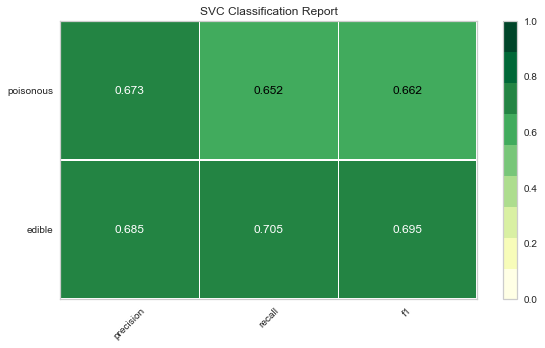

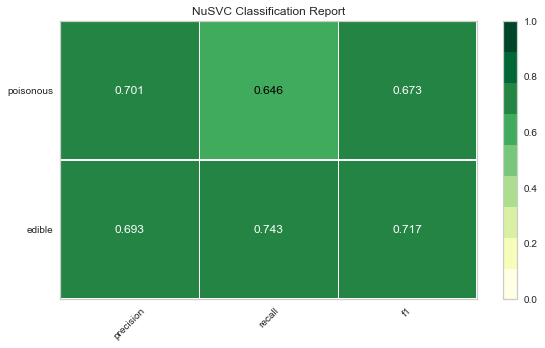

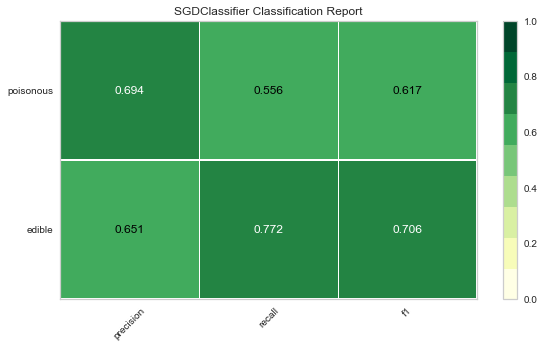

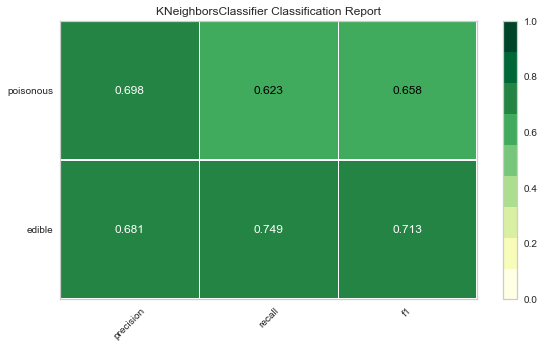

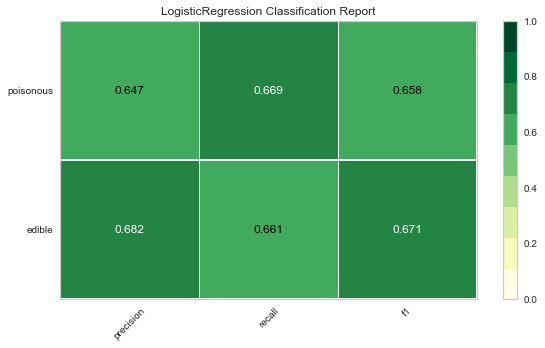

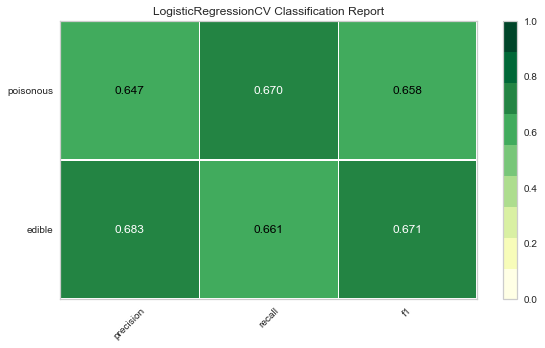

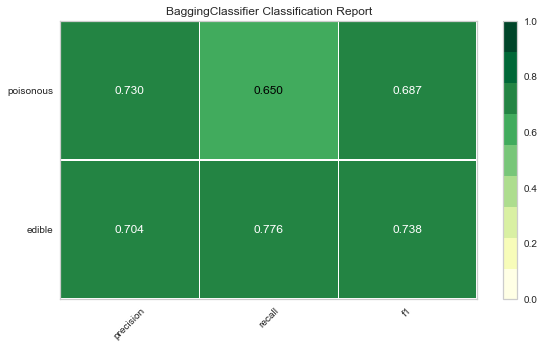

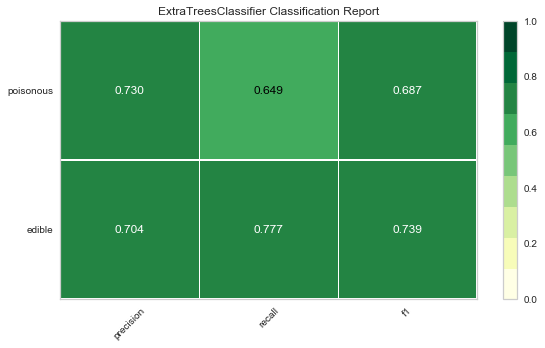

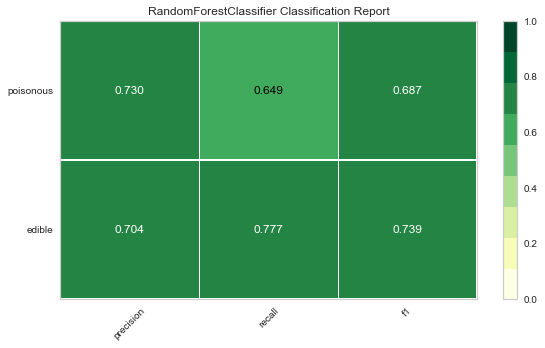

In [4]:
rpts.yellowbrick_model_evaluation_report(X, y, models)

---
# Alternate visualizations:
* <h3>HTML table (with Pandas Style)</h3>
* <h3>Bar plot</h3>
---

## Table output with class & support in column headers:
### &rarr; using `model_evaluation_report_tbl(models, X, y, labels, caption)`:

In [5]:
rpts.model_evaluation_report_tbl(models, X, y, labels, 'Model selection report')

## Bar plot output 
### &rarr; using `model_evaluation_report_bar(models, X, y, labels)`:

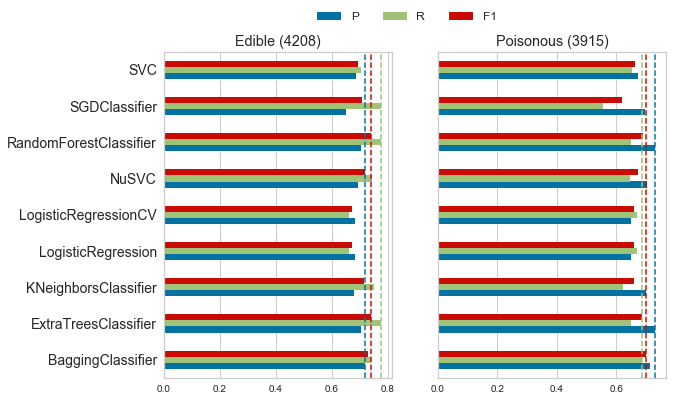

In [6]:
rpts.model_evaluation_report_bar(models, X, y, labels, xlim_to_1=False, encode=True)
# Note: xlim_to_1=False, encode=True :: default values

### same with x-limit set to 1:

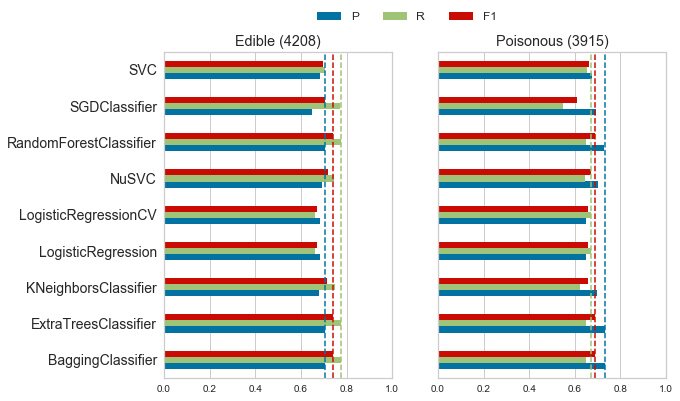

In [7]:
rpts.model_evaluation_report_bar(models, X, y, labels, xlim_to_1=True)

## Example with a multi-class classification

In [8]:
# Iris dataset from sklearn & same models:
X, y, labels = rpts.get_iris_data()
models = rpts.get_models()

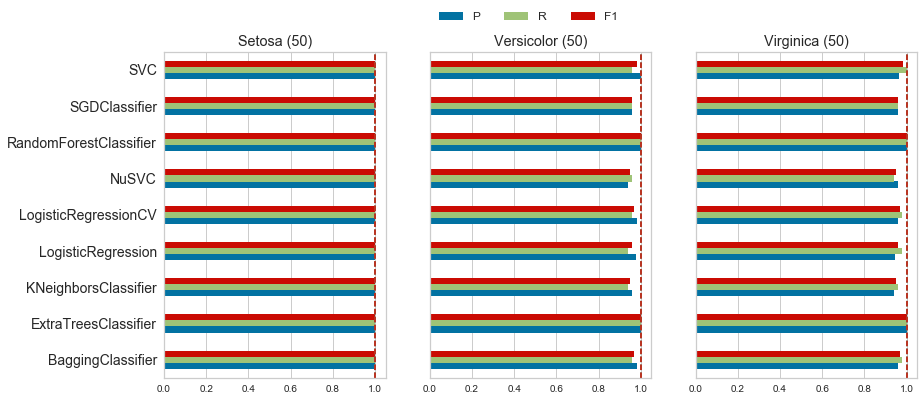

In [9]:
# The encoding is alredy done on this dataset, so encode=False.
rpts.model_evaluation_report_bar(models, X, y, labels, encode=False)

## Clearly, the model scores depend on the model **and** the dataset.

---
# Using radar plots: one plot for each class.

*I've attempted reproducing the radar plots in a single row (whenever possible), but that implementation needs more work as the plots end up being squished too close together.*

I'm glad I went through adapting DeepMind/bsuite radar charts, but I am I not quite satisfied with the outcome, at least with the Iris dataset: they only make it easy to id the least performant model, here SGDClassifier.  
Additionally, until &mdash; and if &mdash; I find a way to line up the plots more compactly, they also suffer from the same 'scrolling objection' I initially made...with only 3 classes!

In [10]:
# Iris dataset from sklearn & same models:
X, y, labels = rpts.get_iris_data()
models = rpts.get_models()

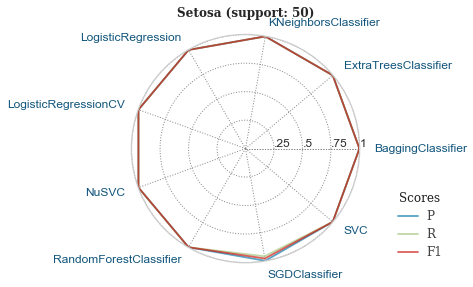

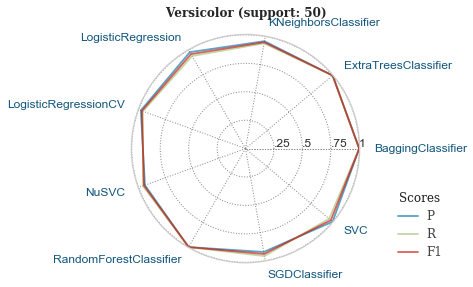

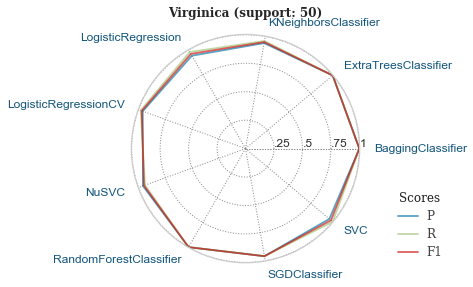

In [11]:
dfm_iris = rpts.get_scores_df(models, X, y, labels, encode=False)

for lbl in labels:
    rpts.scores_radar_plot_example(dfm_iris, cat=lbl)

---
---
# Implementation notes: `get_scores_df()`

This function has a parameter, `class_col`, that acts as a swicth to output either the scores or classes as columns.  
Only the reporting function using the Pandas Styler, `model_evaluation_report_tbl()`, requires `class_col=True`, while the others do not (default = False).

In [12]:
dfm_iris_tbl = rpts.get_scores_df(models, X, y, labels, encode=False, class_col=True)
dfm_iris_tbl.head()

setosa  versicolor  virginica
BaggingClassifier    F1          1.0    0.989899   0.990099
                     P           1.0    1.000000   0.980392
                     R           1.0    0.980000   1.000000
                     Support    50.0   50.000000  50.000000
ExtraTreesClassifier F1          1.0    1.000000   1.000000

In [13]:
dfm_iris = rpts.get_scores_df(models, X, y, labels, encode=False)
dfm_iris.head()

P    R   F1  Support
BaggingClassifier    setosa      1.0  1.0  1.0       50
                     versicolor  1.0  1.0  1.0       50
                     virginica   1.0  1.0  1.0       50
ExtraTreesClassifier setosa      1.0  1.0  1.0       50
                     versicolor  1.0  1.0  1.0       50

## Either df can be passed through the styler function, so this 'DataFrame approach' could be the most straightforward for cases with a large number of classes:

In [14]:
rpts.model_evaluation_report_from_df(dfm_iris_tbl, 'Model selection report (from df)')

In [15]:
rpts.model_evaluation_report_from_df(dfm_iris, 'Model selection report (from df)')